# 56 门控循环单元 GRU

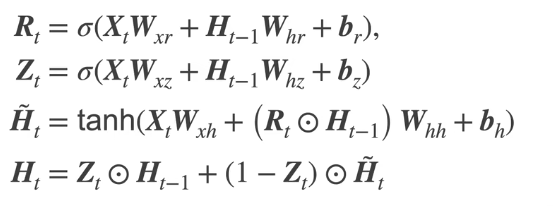
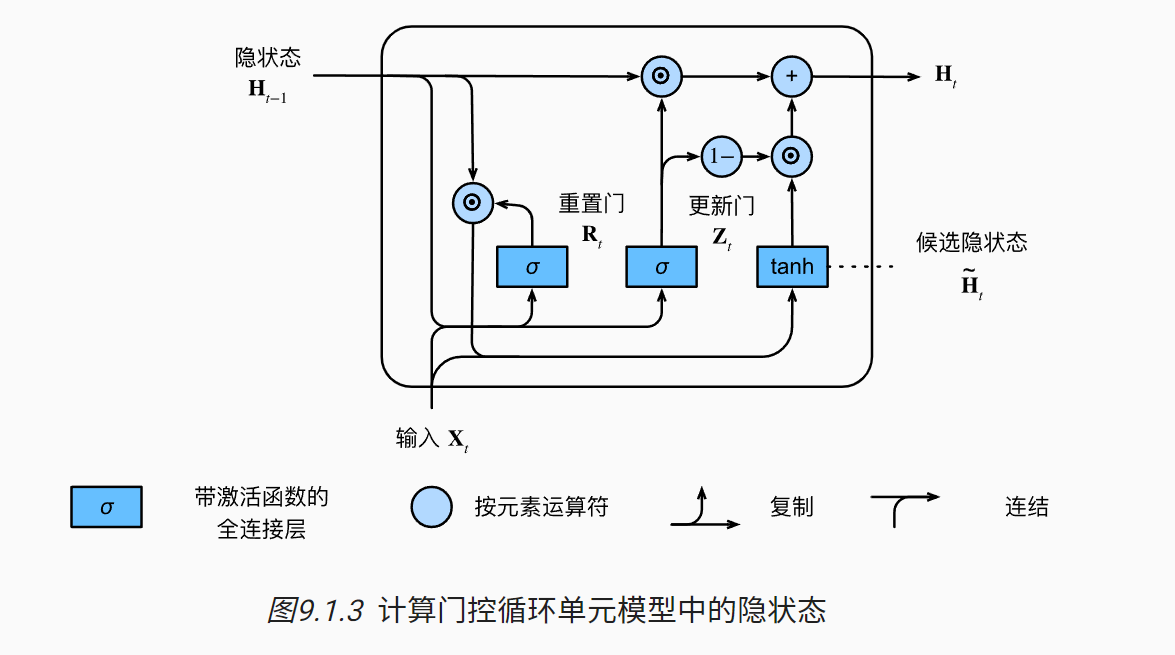

门控循环单元具有以下两个显著特征：
</BR>
重置门有助于捕获序列中的短期依赖关系
</BR>
更新门有助于捕获序列中的长期依赖关系

reset更新新隐藏状态的时候，要使用多少过去隐藏状态的信息，一定会看Xt。
updata 在算当前真正的新隐藏状态的时候，要用多少现在候选隐藏状态信息和要用多少Ht-1。可以完全不看Xt

## 1 从零开始实现

读取时间机器数据集

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 1.1 初始化模型参数

下一步是初始化模型参数。 我们从标准差为0.01的高斯分布中提取权重， 并将偏置项设为0，超参数num_hiddens定义隐藏单元的数量， 实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [3]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 1.2 定义模型
现在我们将定义隐状态的初始化函数init_gru_state。 与 8.5节中定义的init_rnn_state函数一样， 此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [4]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备定义门控循环单元模型， 模型的架构与基本的循环神经网络单元是相同的， 只是权重更新公式更为复杂

In [5]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        # 更新门
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        # 重置门
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        # 候选隐状态
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    # 将所有时间步的输出连接在一起，得到一个形状为 (时间步数量 * 批量大小, 词表大小) 的输出张量
    return torch.cat(outputs, dim=0), (H,)

### 1.3 训练与预测
训练结束后，我们分别打印输出训练集的困惑度， 以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

perplexity 1.1, 37828.4 tokens/sec on cuda:0
time traveller but fermiry if timublustedtinnismingsian mane thi
traveller with a slight accession ofcheerfurand hespess his


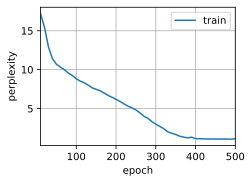

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 2 简洁实现

perplexity 1.0, 407187.5 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


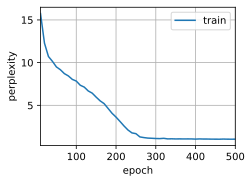

In [7]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
</br>
重置门有助于捕获序列中的短期依赖关系。
</br>
更新门有助于捕获序列中的长期依赖关系。
</br>
重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。

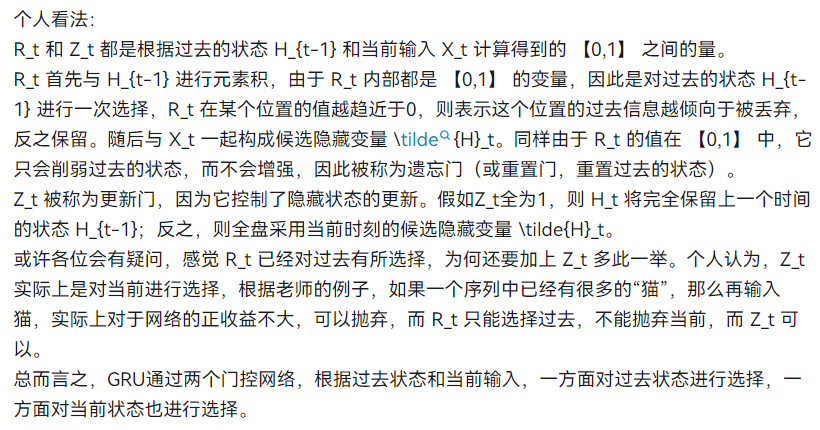